In [1]:
import pandas as pd 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np 
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns 
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import xgboost as xgb
from datetime import date
from statsmodels.stats.weightstats import ttest_ind
from scipy.stats import skew
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from scipy import stats

In [22]:
def model_perform(X_train,y_train, X_test, y_test, model, name, verbose = 0 ):
    # train 
    model.fit(X_train, y_train)

    # test 
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)


    if verbose == 1 :
        print(' MAE {} '.format(mean_absolute_error(y_pred_test,y_test)))
        print(' MSE {} '.format(mean_squared_error(y_pred_test,y_test)))
        print(' R2 {} '.format(r2_score(y_train,y_pred_train)))
    else : 
        pass 
    
    result = {}
    result['mae'] = np.round(mean_absolute_error(y_pred_test,y_test),5)
    result['mse'] = np.round(mean_squared_error(y_pred_test,y_test),5)
    result['R2'] = np.round(r2_score(y_train,y_pred_train),5)
    result['name'] = name
    result['feature_size'] = X_train.shape[1]
    result['train_size'] = X_train.shape[0]
    result['test_size'] = X_test.shape[0]

    return model, y_pred_test, y_pred_train, result 

def show_error_pattern(y_pred, y_test):
    result_test = pd.DataFrame()
    result_test['score'] = y_pred
    result_test['type'] = 'predict'
    result_test['idx'] = np.arange(result_test.shape[0])

    result_test2 = pd.DataFrame()
    result_test2['score'] = np.squeeze(y_test)
    result_test2['type'] = 'test'
    result_test2['idx'] = np.arange(result_test2.shape[0])

    df_result = pd.concat([result_test2,result_test])

    sns.lineplot(data=df_result, x="idx", y='score', hue="type")


def bulk_train(df_input, drop_column, target_column, dataset_name,  rf_param, xgb_param, svr_param, verbose = 0,):

    error_report = []
    model_dict = {}


    # remove 0 rating
    df_input = df_input[df_input['rating']>0]

    # scaled the values 
    features_columns = df_input.drop(drop_column,axis=1).columns
    features_columns = list(features_columns) + [target_column]
    scaler = MinMaxScaler()
    df_input_scale = pd.DataFrame(scaler.fit_transform(df_input[features_columns]), columns = features_columns)
    


    # split train and test 
    X_train, X_test, y_train, y_test = train_test_split(df_input_scale.drop(target_column, axis=1), df_input_scale[target_column], test_size=0.12, random_state=42)

    regr = RandomForestRegressor(random_state=0)
    model_regr, y_pred_test_regr, y_pred_train_regr, result_rf   = model_perform(X_train, y_train, X_test, y_test, regr, name='rf', verbose = verbose )
    error_report.append(result_rf)

    xgbr = XGBRegressor(random_state=0)
    model_xgbr, y_pred_test_xgbr, y_pred_train_xgbr, result_xgb  = model_perform(X_train, y_train, X_test, y_test, xgbr, name='xgb', verbose = verbose)
    error_report.append(result_xgb)

    # SVR 
    svr = SVR(kernel='poly')
    model_svr, y_pred_test_svr, y_pred_train_svr, result_svr  = model_perform(X_train, y_train, X_test, y_test, svr, name='svr',verbose = verbose)
    error_report.append(result_svr)

    model_dict['rf'] = model_regr
    model_dict['xgbr'] = result_xgb
    model_dict['svr'] = result_svr
    
    df_report = pd.DataFrame(error_report)
    df_report['dataset'] = dataset_name
    return  model_dict, df_report


def bulk_train_k_fold(df_input, drop_column, target_column, dataset_name, rf_param, xgb_param, svr_param, verbose = 0):

        
    # remove 0 rating
    df_input = df_input[df_input['rating'] > 0]

    # scaled the values 
    features_columns = df_input.drop(drop_column,axis=1).columns
    features_columns = list(features_columns) + [target_column]
    scaler = MinMaxScaler()
    df_input_scale = pd.DataFrame(scaler.fit_transform(df_input[features_columns]), columns = features_columns)

    # split train and test 
    X_train, X_test, y_train, y_test = train_test_split(df_input_scale.drop(target_column, axis=1), df_input_scale[target_column], test_size=0.12, random_state=42)

    # cross validation 
    scoring = ['neg_mean_absolute_error','neg_mean_squared_error','r2']

    if rf_param:
        regr = RandomForestRegressor(**rf_param)
    else :
        regr = RandomForestRegressor(random_state=0)
        
    result_rf = cross_validation(regr, X_train, y_train, scoring = scoring, cv =5 )
    df_rf = pd.DataFrame(result_rf)
    df_rf['name'] = 'rf'

    if xgb_param:
        xgbr = XGBRegressor(**xgb_param)
    else :
        xgbr = XGBRegressor(random_state=0)

    result_xgb = cross_validation(xgbr, X_train, y_train, scoring = scoring, cv =5 )
    df_xgb = pd.DataFrame(result_xgb)
    df_xgb['name'] = 'xgb'


    if svr_param:
        svr = SVR(**svr_param)
    else :
        svr = SVR(kernel='poly')

    result_svr = cross_validation(svr, X_train, y_train, scoring = scoring, cv =5 )
    df_svr = pd.DataFrame(result_svr)
    df_svr['name'] = 'svr'

    df_result = pd.concat([df_rf,df_xgb,df_svr])
    df_result['dataset'] = dataset_name

    # Singe train and test 
    single_result = []

    # random forest
    tmp_result = {} 
    regr.fit(X_train,y_train)
    y_pred = regr.predict(X_test)
    tmp_result['mae'] = mean_absolute_error(y_pred, y_test)
    tmp_result['mse'] = mean_squared_error(y_pred, y_test)
    tmp_result['pearson'] = stats.pearsonr(y_pred, y_test)[0]
    tmp_result['name'] = 'rf'
    tmp_result['dataset'] = dataset_name
    tmp_result['feature_size'] = len(X_train.columns)
    tmp_result['train_size'] = X_train.shape[0]
    tmp_result['test_size'] = X_test.shape[0]
    single_result.append(tmp_result)

    # random forest
    tmp_result = {} 
    xgbr.fit(X_train,y_train)
    y_pred = xgbr.predict(X_test)
    tmp_result['mae'] = mean_absolute_error(y_pred, y_test)
    tmp_result['mse'] = mean_squared_error(y_pred, y_test)
    tmp_result['pearson'] = stats.pearsonr(y_pred, y_test)[0]
    tmp_result['name'] = 'xgb'
    tmp_result['dataset'] = dataset_name
    tmp_result['feature_size'] = len(X_train.columns)
    tmp_result['train_size'] = X_train.shape[0]
    tmp_result['test_size'] = X_test.shape[0]
    single_result.append(tmp_result)

    #svr 
    tmp_result = {} 
    svr.fit(X_train,y_train)
    y_pred = svr.predict(X_test)
    tmp_result['mae'] = mean_absolute_error(y_pred, y_test)
    tmp_result['mse'] = mean_squared_error(y_pred, y_test)
    tmp_result['pearson'] = stats.pearsonr(y_pred, y_test)[0]
    tmp_result['name'] = 'svr'
    tmp_result['dataset'] = dataset_name
    tmp_result['feature_size'] = len(X_train.columns)
    tmp_result['train_size'] = X_train.shape[0]
    tmp_result['test_size'] = X_test.shape[0]
    single_result.append(tmp_result)

    df_result_singel = pd.DataFrame(single_result)


    return df_result, df_result_singel


def cross_validation(model, X, y, scoring, cv=5):

    results = cross_validate(estimator=model,
                               X=X,
                               y=y,
                               cv=cv,
                               scoring=scoring,
                               return_train_score=True)

    return results


# Zomato

In [23]:
# zomato only
df_zom = pd.read_csv('data/3_clean_zomato_feat.csv')
# df_zom = pd.read_csv('data/3_jbdk_clean_zomato_feat.csv')

df_zom['rest_price_idr'] = df_zom['rest_price_idr'] / 1000
df_zom['rest_price_idr'] = df_zom['rest_price_idr'].astype(int)

drop_column = ['url','index','rating','lat','long','review','new_code_res_type','new_code_fac']
target_column = 'rating'

# cross validation 

rf_param = {'n_estimators':1000,'max_features':2, 'max_depth':30,'bootstrap':True}
xgb_param = {'n_estimators':100, 'max_depth':30, 'min_child_weight':1, 'learning_rate':0.2, 'booster':'gbtree'}
svr_param  = {'kernel':'poly','gamma':1,'C':10}


result_zomato_loop, result_zomato = bulk_train_k_fold(df_input=df_zom, drop_column=drop_column, target_column=target_column, dataset_name='zomato_only', rf_param = rf_param, xgb_param=xgb_param, svr_param=svr_param)
result_zomato_loop['test_neg_mean_squared_error']= result_zomato_loop['test_neg_mean_squared_error']*-1
result_zomato_loop['test_neg_mean_absolute_error']= result_zomato_loop['test_neg_mean_absolute_error']*-1
result_zomato_loop['feature_size'] = len(df_zom.drop(drop_column, axis=1).columns)
result_zomato_loop['record'] = df_zom.drop(drop_column, axis=1).shape[0]
result_zomato_loop = result_zomato_loop.reset_index()

# Zomato 250 

In [24]:
# zomato geo 250
df_zom_poi = pd.read_csv('data/3_clean_zomato_gof_250.csv')
# df_zom_poi = pd.read_csv('data/3_jbdk_clean_zomato_gof_250.csv')
df_zom_poi['rest_price_idr'] = df_zom_poi['rest_price_idr'] / 1000
df_zom_poi['rest_price_idr'] = df_zom_poi['rest_price_idr'].astype(int)

drop_column = ['url','index','rating','lat','long','review','new_code_res_type','new_code_fac','geohash','encode']
target_column = 'rating'

# cross validation
rf_param = {'n_estimators':250,'max_features':2, 'max_depth':30,'bootstrap':True}
xgb_param = {'n_estimators':900, 'max_depth':3, 'min_child_weight':2, 'learning_rate':0.05, 'booster':'gbtree'}
svr_param  = {'kernel':'poly','gamma':0.1,'C':100}

result_zomato_250_loop,  result_zomato_250  = bulk_train_k_fold(df_input=df_zom_poi, drop_column=drop_column, target_column=target_column, dataset_name='zomato_poi_250',rf_param = rf_param, xgb_param=xgb_param, svr_param=svr_param)
result_zomato_250_loop['test_neg_mean_squared_error'] = result_zomato_250_loop['test_neg_mean_squared_error']*-1
result_zomato_250_loop['test_neg_mean_absolute_error'] = result_zomato_250_loop['test_neg_mean_absolute_error']*-1
result_zomato_250_loop['feature_size'] = len(df_zom_poi.drop(drop_column, axis=1).columns)
result_zomato_250_loop['record'] = df_zom_poi.drop(drop_column, axis=1).shape[0]

result_zomato_250_loop = result_zomato_250_loop.reset_index()

# Zomato 500 

In [25]:
# zomato geo 500
df_zom_poi = pd.read_csv('data/3_clean_zomato_gof_500.csv')
# df_zom_poi = pd.read_csv('data/3_jbdk_clean_zomato_gof_500.csv')
df_zom_poi['rest_price_idr'] = df_zom_poi['rest_price_idr'] / 1000
df_zom_poi['rest_price_idr'] = df_zom_poi['rest_price_idr'].astype(int)

drop_column = ['url','index','rating','lat','long','review','new_code_res_type','new_code_fac','geohash','encode']
target_column = 'rating'

# cross validation
rf_param = {'n_estimators':500,'max_features':3, 'max_depth':100,'bootstrap':True}
xgb_param = {'n_estimators':900, 'max_depth':2, 'min_child_weight':3, 'learning_rate':0.05, 'booster':'gbtree'}
svr_param  = {'kernel':'poly','gamma':0.1,'C':10}

result_zomato_500_loop,  result_zomato_500 = bulk_train_k_fold(df_input=df_zom_poi, drop_column=drop_column, target_column=target_column, dataset_name='zomato_poi_500', rf_param = rf_param, xgb_param=xgb_param, svr_param=svr_param)
result_zomato_500_loop['test_neg_mean_squared_error'] = result_zomato_500_loop['test_neg_mean_squared_error']*-1
result_zomato_500_loop['test_neg_mean_absolute_error'] = result_zomato_500_loop['test_neg_mean_absolute_error']*-1
result_zomato_500_loop['feature_size'] = len(df_zom_poi.drop(drop_column, axis=1).columns)
result_zomato_500_loop['record'] = df_zom_poi.drop(drop_column, axis=1).shape[0]

result_zomato_500_loop = result_zomato_500_loop.reset_index()

# Zomato 1000

In [26]:
# zomato geo 1000
df_zom_poi = pd.read_csv('data/3_clean_zomato_gof_1000.csv')
# df_zom_poi = pd.read_csv('data/3_jbdk_clean_zomato_gof_1000.csv')
df_zom_poi['rest_price_idr'] = df_zom_poi['rest_price_idr'] / 1000
df_zom_poi['rest_price_idr'] = df_zom_poi['rest_price_idr'].astype(int)

drop_column = ['url','index','rating','lat','long','review','new_code_res_type','new_code_fac','geohash','encode']
target_column = 'rating'

# cross validation
rf_param = {'n_estimators':500,'max_features':3, 'max_depth':250,'bootstrap':True}
xgb_param = {'n_estimators':100, 'max_depth':5, 'min_child_weight':4, 'learning_rate':0.1, 'booster':'gbtree'}
svr_param  = {'kernel':'poly','gamma':0.1,'C':10}


result_zomato_1000_loop,  result_zomato_1000 = bulk_train_k_fold(df_input=df_zom_poi, drop_column=drop_column, target_column=target_column, dataset_name='zomato_poi_1000',rf_param = rf_param, xgb_param=xgb_param, svr_param=svr_param)
result_zomato_1000_loop['test_neg_mean_squared_error'] = result_zomato_1000_loop['test_neg_mean_squared_error']*-1
result_zomato_1000_loop['test_neg_mean_absolute_error'] = result_zomato_1000_loop['test_neg_mean_absolute_error']*-1
result_zomato_1000_loop['feature_size'] = len(df_zom_poi.drop(drop_column, axis=1).columns)
result_zomato_1000_loop['record'] = df_zom_poi.drop(drop_column, axis=1).shape[0]


result_zomato_1000_loop = result_zomato_1000_loop.reset_index()

In [27]:
# cross validation 
df_total_result = pd.concat([result_zomato_loop,result_zomato_250_loop, result_zomato_500_loop, result_zomato_1000_loop])

# train and test 
df_total_normal = pd.concat([result_zomato , result_zomato_250, result_zomato_500, result_zomato_1000])

In [28]:
df_total_normal

,mae,mse,pearson,name,dataset,feature_size,train_size,test_size
0,0.126184,0.026667,0.421703,rf,zomato_only,4,5105,697
1,0.137168,0.032082,0.380185,xgb,zomato_only,4,5105,697
2,0.136571,0.030197,0.221412,svr,zomato_only,4,5105,697
0,0.133378,0.028631,0.312926,rf,zomato_poi_250,23,5105,697
1,0.132922,0.029058,0.304311,xgb,zomato_poi_250,23,5105,697
2,0.134657,0.029486,0.260898,svr,zomato_poi_250,23,5105,697
0,0.127665,0.026732,0.390540,rf,zomato_poi_500,23,5105,697
1,0.128499,0.027124,0.374893,xgb,zomato_poi_500,23,5105,697
2,0.132552,0.028215,0.324573,svr,zomato_poi_500,23,5105,697
0,0.127989,0.026784,0.388211,rf,zomato_poi_1000,23,5105,697


In [30]:
today = date.today()
print("Today's date:", today)

Today's date: 2022-11-18


In [31]:
df_total_result.to_excel('data/ml_perform_crossval_raw_{}.xlsx'.format(today),index=False)
df_total_normal.to_excel('data/ml_perform_normal_{}.xlsx'.format(today),index=False)

In [10]:
df_zom_poi.drop(drop_column, axis=1).columns

Index(['rest_price_idr', 'is_chain', 'rank_res_type', 'rank_fac',
       'd_1000_airport', 'd_1000_atm', 'd_1000_bank', 'd_1000_cafe',
       'd_1000_convenience_store', 'd_1000_gas_station', 'd_1000_hospital',
       'd_1000_lodging', 'd_1000_meal_takeaway', 'd_1000_mosque',
       'd_1000_park', 'd_1000_restaurant', 'd_1000_school', 'd_1000_store',
       'd_1000_supermarket', 'd_1000_train_station', 'en_1000', 'n_compt_1000',
       'avg_n_rest'],
      dtype='object')

In [11]:
df_total_result.head()

,index,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_squared_error,train_neg_mean_squared_error,test_r2,train_r2,name,dataset,feature_size,record
0,0,6.585891,0.301733,0.127254,-0.055708,0.026202,-0.005479,0.130686,0.803291,rf,zomato_only,4,5803
1,1,5.923036,0.281250,0.130779,-0.055833,0.026724,-0.005517,0.101567,0.799304,rf,zomato_only,4,5803
2,2,5.839658,0.260279,0.120819,-0.055903,0.024385,-0.005513,0.141171,0.805996,rf,zomato_only,4,5803
3,3,5.581284,0.299199,0.118985,-0.055942,0.023777,-0.005606,0.076523,0.805752,rf,zomato_only,4,5803
4,4,5.194567,0.247341,0.118884,-0.056355,0.023310,-0.005693,0.026359,0.805497,rf,zomato_only,4,5803


# Aggregate report 

In [12]:
df_total_result_agg = df_total_result.groupby(['name','dataset','feature_size']).agg({'test_neg_mean_absolute_error':['mean','std','median'],'test_neg_mean_squared_error':['mean','std','median']}).reset_index()
df_total_result_agg.columns = ['name','dataset','feature_size','avg_mae','std_mae','med_mae','avg_mse','std_mse','med_mse']

df_total_result_agg.to_excel('data/ml_perform_crossval_agg_{}.xlsx'.format(today),index=False)

In [13]:
df_total_result_agg

,name,dataset,feature_size,avg_mae,std_mae,med_mae,avg_mse,std_mse,med_mse
0,rf,zomato_only,4,0.123344,0.005381,0.120819,0.024880,0.001506,0.024385
1,rf,zomato_poi_1000,23,0.132298,0.006643,0.131435,0.027040,0.001471,0.027266
2,rf,zomato_poi_250,23,0.128468,0.006410,0.127380,0.025942,0.001273,0.025803
3,rf,zomato_poi_500,23,0.130282,0.005529,0.130602,0.026438,0.001093,0.026884
4,svr,zomato_only,4,0.130523,0.006411,0.129927,0.026956,0.001426,0.026779
5,svr,zomato_poi_1000,23,0.132814,0.005365,0.133082,0.027948,0.001599,0.028475
6,svr,zomato_poi_250,23,0.134292,0.007916,0.132651,0.028624,0.002624,0.027751
7,svr,zomato_poi_500,23,0.133436,0.005278,0.134503,0.027957,0.001130,0.028366
8,xgb,zomato_only,4,0.136144,0.005520,0.137832,0.030674,0.002112,0.031544
9,xgb,zomato_poi_1000,23,0.132433,0.006067,0.130594,0.027542,0.001992,0.027105


<AxesSubplot:title={'center':'Quality'}>

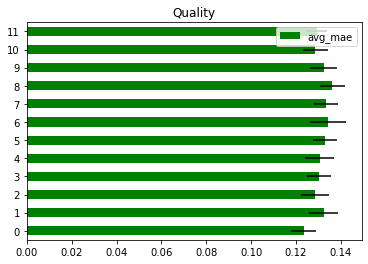

In [14]:
df_total_result_agg.plot(kind = "barh", y = "avg_mae", legend = True, xerr = "std_mae", title = "Quality", color='green')